## RISHABH KANNOJIA
## 21BPS1532
## Cyber Security (CSE4003)

# Federated Never Ending Learning

### Importing required libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

### Mounting the *google drive*

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

### Loading the dataset

In [ ]:
df = pd.read_csv('/content/drive/My Drive/CICIDS_test.csv', skipinitialspace=True)

## Dataset Description

In [ ]:
df.head()

In [ ]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566149 entries, 0 to 566148
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             566149 non-null  int64  
 1   Flow Duration                566149 non-null  float64
 2   Total Fwd Packets            566149 non-null  int64  
 3   Total Backward Packets       566149 non-null  int64  
 4   Total Length of Fwd Packets  566149 non-null  int64  
 5   Total Length of Bwd Packets  566149 non-null  int64  
 6   Fwd Packet Length Max        566149 non-null  int64  
 7   Fwd Packet Length Min        566149 non-null  int64  
 8   Fwd Packet Length Mean       566149 non-null  float64
 9   Fwd Packet Length Std        566149 non-null  float64
 10  Bwd Packet Length Max        566149 non-null  int64  
 11  Bwd Packet Length Min        566149 non-null  int64  
 12  Bwd Packet Length Mean       566149 non-null  float64
 13 

### From here, it can be concluded that the dataset has no missing value, also all the features doesn't categorical data, hence due to these reason, it can be said that the data is cleaned

## Data Preparation and Preprocessing

- Data Preparation:
    - We first read the csv into a dataframe
    - We then separate the data and the labels into two matrices `X` and `Y`
- Data Preprocessing:
    - The data was first normalized, this centers each attribute of the data around 0.
    - We then use a min-max scaler to rescale the data.
- These steps ensure that the ML algorithm gets the most out of the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, Normalizer

X = df.loc[:, df.columns != 'Label'] #Defining 'X' as a dataset without 'Label' column as that of 'df'
X = Normalizer().fit_transform(X) #Normalizing the data
X = MinMaxScaler().fit_transform(X) #Scaling the data
Y = df[['Label']].to_numpy() #Created a numpy array 'Y' of column 'Label' of 'df'

In [ ]:
print(X.shape)
print(Y.shape)
print(len(np.unique(Y))) #Unique Lables in Y
pd.value_counts(Y.ravel()) #Frequency of each class Label

(566149, 78)
(566149, 1)
15


0     454620
4      46215
10     31786
2      25606
3       2059
7       1588
11      1179
6       1159
5       1100
1        393
12       301
14       130
9          7
13         4
8          2
dtype: int64

### Here we can conclude that the dataset is imbalanced.

## Classification Models

- The `BinaryClassification` and `MulticlassClassification` class encapsulates a keras MLP model.
- The number of layers and the input size can be passed in the constructor.
- All of the methods we need later are abstracted away in this class so we can focus on the results rather than the implementation.
- There are 4 main methods:
    - The constructor: takes the input size, output size (for multiclassification) and the number of layers needed. It then creates and compiles the model using `keras`.
    - `fit`: takes the training data and trains the model
    - `predict`: takes the testing dataset, generates predictions and then evaluates the results.
    - `set_avg_weights`: Implements federated learning. Takes a list of models (of the same class) and replaces the current weights with the average of the models give.

In [ ]:
class BinaryClassification:
    def __init__(self, input_dims, layers):
        self.model = Sequential(name="server_model") #Keras model creation, model name is "server_model", 'Sequential' type most basic model is used
        self.model.add(Dense( #the first hidden layer, or we can say second layer of neural network is defined
            layers[0],
            input_shape=(input_dims,),
            activation='relu' #rectified linear unit (Incorporating non-linearity property into a deep learning model )
        ))
        for l in layers[1:]: #After first hidden layer, all layers are added using loop
            self.model.add(Dense(l, activation='relu'))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile( #Compiling the model
            loss='binary_crossentropy', #for probability
            optimizer='adam',
            metrics=['accuracy', ] #as it is the most common way to predict the accuracy
        )
        self.model.summary()

    def set_avg_weights(self, models):
        all_weights = np.array([
            model.model.get_weights()
                for model in models
        ])
        avg_weights = np.mean(all_weights, axis=0)
        self.model.set_weights(avg_weights)

    def fit(self, X, Y, epochs, batch_size): #'batch_size' tells that how much samples are to be included in one batch to be passed and processed at a time point of time by neural network
        Y_bin = np.asarray([
            0 if y == 0 else 1 for y in Y.ravel()
        ]).reshape(-1, 1) #converting in 1-D array
        # print(Y_bin.shape)
        # print(pd.value_counts(Y_bin.ravel()))
        self.model.fit(X, Y_bin, epochs=epochs, batch_size=batch_size)

    def predict(self, X, Y):
        Y_bin = np.asarray([
            0 if y == 0 else 1 for y in Y.ravel()
        ]).reshape(-1, 1)
        # print(pd.value_counts(Y_bin.ravel()))

        preds = self.model.predict(X)
        preds = np.where(preds > 0.5, 1, 0)

        # print(Y_bin.shape)
        # print(preds.shape)
        print(classification_report(Y_bin, preds))
        # print(confusion_matrix(Y_bin, preds))
        ConfusionMatrixDisplay.from_predictions(Y_bin, preds)


In [ ]:
class MulticlassClassification:
    def __init__(self, input_dims, layers, num_classes):
        self.model = Sequential(name="server_model")
        self.model.add(Dense(
            layers[0],
            input_shape=(input_dims,),
            activation='relu'
        ))
        for l in layers[1:]:
            self.model.add(Dense(l, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax')) #"num_classes" telling the no. of nodes in the last layer, so here final layer will contain 15 nodes, and maximum possibility of node will be the answer
        self.model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        self.model.summary()

    def set_avg_weights(self, models):
        all_weights = np.array([
            model.model.get_weights()
                for model in models
        ])
        avg_weights = np.mean(all_weights, axis=0)
        self.model.set_weights(avg_weights)

    def fit(self, X, Y, epochs, batch_size):
        # print(pd.value_counts(Y.ravel()))
        self.model.fit(X, Y.ravel(), epochs=epochs, batch_size=batch_size)

    def predict(self, X, Y):
        # print(pd.value_counts(Y.ravel()))

        preds = self.model.predict(X)
        preds = [np.argmax(p) for p in preds] #Max possibilty is taken from the array

        print(classification_report(Y, preds))
        # print(confusion_matrix(Y, preds))
        ConfusionMatrixDisplay.from_predictions(Y, preds)



## Non-Federated

- We first use the above classes for normal, non-federated learning to see what results we get.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=1)

print(X_train.shape)
print(Y_train.shape)
print(np.unique(Y_train))
print(pd.value_counts(Y_train.ravel()))

print(X_test.shape)
print(Y_test.shape)
print(np.unique(Y_test))
print(pd.value_counts(Y_test.ravel()))

(396304, 78)
(396304, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0     318395
4      32391
10     22137
2      17891
3       1417
7       1123
11       827
6        786
5        780
1        257
12       197
14        92
9          7
13         2
8          2
dtype: int64
(169845, 78)
(169845, 1)
[ 0  1  2  3  4  5  6  7 10 11 12 13 14]
0     136225
4      13824
10      9649
2       7715
3        642
7        465
6        373
11       352
5        320
1        136
12       104
14        38
13         2
dtype: int64


### Binary Classification into Malicious

1.   List item
2.   List item



In [ ]:
model_binary = BinaryClassification(
    input_dims=78,
    layers=[20, 20, 20]
)
model_binary.fit(X_train, Y_train, epochs=20, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1580      
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12385/12385 [==============================] - 60s 4ms/step - loss: 0.0913 - accuracy: 0.9675
Epoch 2/20
12385/12385 [==============================] - 55s 4ms/step - loss: 

5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    136225
           1       0.99      0.99      0.99     33620

    accuracy                           1.00    169845
   macro avg       0.99      0.99      0.99    169845
weighted avg       1.00      1.00      1.00    169845



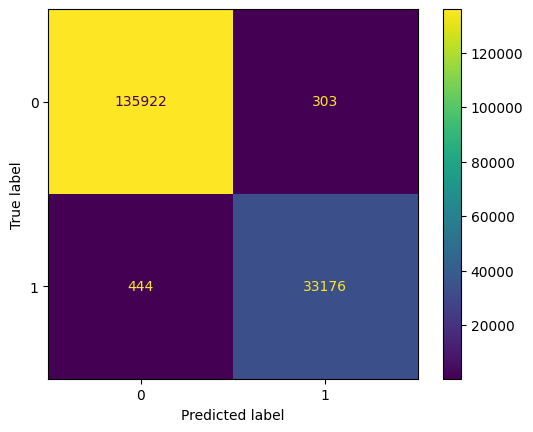

In [ ]:
model_binary.predict(X_test, Y_test)

- We can see that the binary classification works very well with a high accuracy and a high f1-score.

### MultiClass Classification


In [ ]:
model_sf = MulticlassClassification(
    input_dims=78,
    layers=[20, 20, 20],
    num_classes=15
)
model_sf.fit(X_train, Y_train, epochs=20, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 20)                1580      
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12385/12385 [==============================] - 48s 4ms/step - loss: 0.1749 - accuracy: 0.9477
Epoch 2/20
12385/12385 [==============================] - 45s 4ms/step - loss: 

5308/5308 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    136225
           1       0.96      0.35      0.52       136
           2       0.98      0.99      0.99      7715
           3       0.94      0.96      0.95       642
           4       0.99      0.99      0.99     13824
           5       0.76      0.74      0.75       320
           6       0.94      0.69      0.80       373
           7       0.99      1.00      0.99       465
          10       0.99      1.00      0.99      9649
          11       0.95      0.97      0.96       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.99    169845
   macro avg       0.73      0.67      0.69    169845
weighted avg       0.99      0.99      0.99    169845



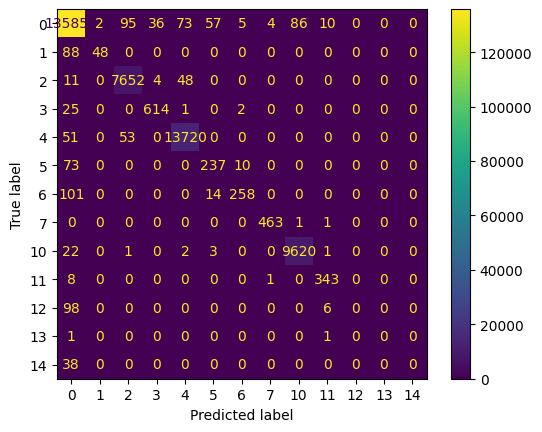

In [ ]:
model_sf.predict(X_test, Y_test)

- The multiclass classification works well for the classes with enough samples in the dataset.
- However, some minority classes got completely ignored, this can be improved upon by using an appropriate method to handle class imbalance.

## Federated Learning

In [ ]:
X_1, X_2, Y_1, Y_2 = train_test_split(X_train, Y_train, train_size=0.5, random_state=1)

In [ ]:
print(X_1.shape)
print(Y_1.shape)
print(np.unique(Y_1))
print(pd.value_counts(Y_1.ravel()))
print(X_2.shape)
print(Y_2.shape)
print(np.unique(Y_2))
print(pd.value_counts(Y_2.ravel()))

(198152, 78)
(198152, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0     158990
4      16294
10     11120
2       8918
3        735
7        561
11       440
5        409
6        392
1        139
12        99
14        51
9          2
8          1
13         1
dtype: int64
(198152, 78)
(198152, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0     159405
4      16097
10     11017
2       8973
3        682
7        562
6        394
11       387
5        371
1        118
12        98
14        41
9          5
8          1
13         1
dtype: int64


### Binary Classification

In [ ]:
model_1 = BinaryClassification(78, [20, 20, 20])
model_1.fit(X_1, Y_1, epochs=20, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                1580      
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6193/6193 [==============================] - 27s 4ms/step - loss: 0.1236 - accuracy: 0.9516
Epoch 2/20
6193/6193 [==============================] - 25s 4ms/step - loss: 0.06

5308/5308 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    136225
           1       0.98      0.98      0.98     33620

    accuracy                           0.99    169845
   macro avg       0.99      0.99      0.99    169845
weighted avg       0.99      0.99      0.99    169845



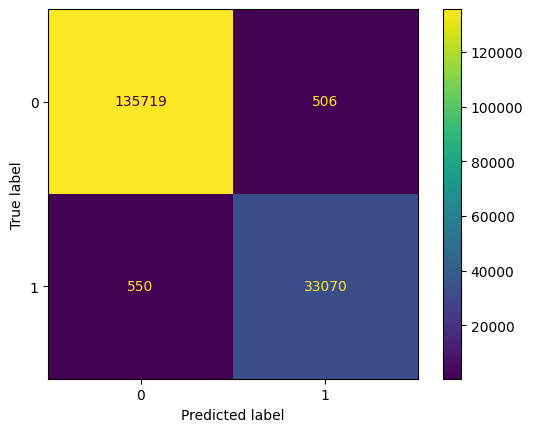

In [ ]:
model_1.predict(X_test, Y_test)

In [ ]:
model_2 = BinaryClassification(78, [20, 20, 20])
model_2.fit(X_2, Y_2, epochs=20, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                1580      
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6193/6193 [==============================] - 27s 4ms/step - loss: 0.1382 - accuracy: 0.9445
Epoch 2/20
6193/6193 [==============================] - 25s 4ms/step - loss: 0.07

5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    136225
           1       0.99      0.98      0.98     33620

    accuracy                           0.99    169845
   macro avg       0.99      0.99      0.99    169845
weighted avg       0.99      0.99      0.99    169845



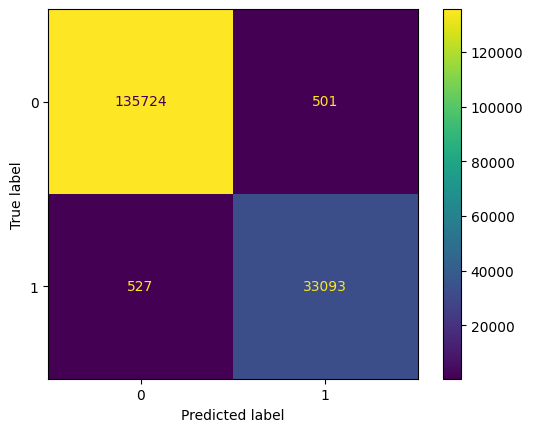

In [ ]:
model_2.predict(X_test, Y_test)

- We trained 2 models on two different datasets above.
- There was no data shared between both models.
- Now, we will use the `set_avg_weights` method to combine both models to set the weights in a third model.

In [ ]:
model_3 = BinaryClassification(78, [20, 20, 20])
model_3.set_avg_weights([model_1, model_2])

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 20)                1580      
                                                                 
 dense_17 (Dense)            (None, 20)                420       
                                                                 
 dense_18 (Dense)            (None, 20)                420       
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________


5308/5308 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91    136225
           1       0.63      0.70      0.66     33620

    accuracy                           0.86    169845
   macro avg       0.78      0.80      0.79    169845
weighted avg       0.87      0.86      0.86    169845



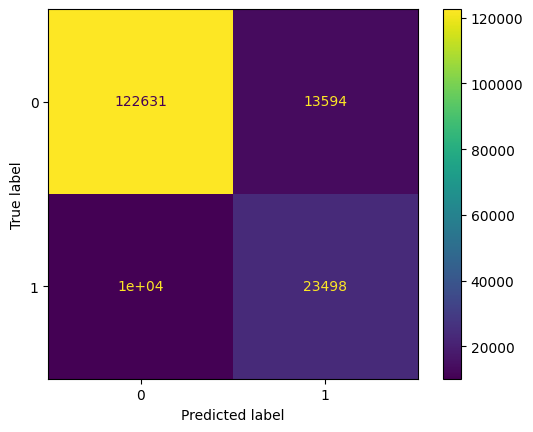

In [ ]:
model_3.predict(X_test, Y_test)

- We see the accuracy has gone down due to a possible reduction in the size of data.
- However, we still used the complete dataset without sharing any data.

### Multiclass Classification

- We did the same process as above for multiclass classification as well.

In [ ]:
model_sf_1 = MulticlassClassification(
    78,
    [20, 20, 20],
    num_classes=15
)
model_sf_1.fit(X_1, Y_1, epochs=20, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 20)                1580      
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                                                                 
 dense_23 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6193/6193 [==============================] - 25s 4ms/step - loss: 0.2376 - accuracy: 0.9279
Epoch 2/20
6193/6193 [==============================] - 23s 4ms/step - loss: 0.11

5308/5308 [==============================] - 10s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    136225
           1       0.96      0.32      0.48       136
           2       0.98      0.98      0.98      7715
           3       0.92      0.96      0.94       642
           4       0.96      0.99      0.97     13824
           5       0.79      0.66      0.72       320
           6       0.94      0.41      0.57       373
           7       0.99      0.86      0.92       465
          10       0.99      0.99      0.99      9649
          11       0.90      0.98      0.94       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.99    169845
   macro avg       0.72      0.63      0.65    169845
weighted avg       0.99      0.99      0.99    169845



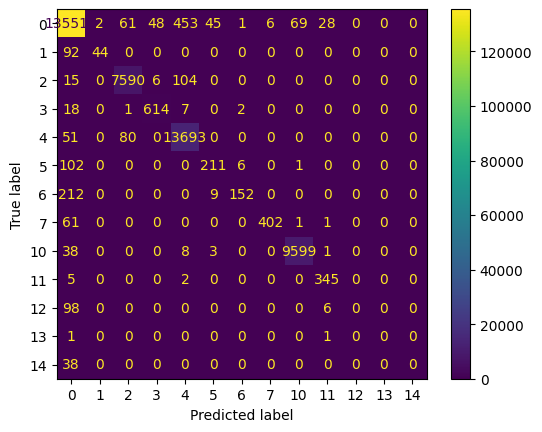

In [ ]:
model_sf_1.predict(X_test, Y_test)

In [ ]:
model_sf_2 = MulticlassClassification(
    78,
    [20, 20, 20],
    num_classes=15
)
model_sf_2.fit(X_2, Y_2, epochs=20, batch_size=32)

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 20)                1580      
                                                                 
 dense_25 (Dense)            (None, 20)                420       
                                                                 
 dense_26 (Dense)            (None, 20)                420       
                                                                 
 dense_27 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6193/6193 [==============================] - 25s 4ms/step - loss: 0.2319 - accuracy: 0.9278
Epoch 2/20
6193/6193 [==============================] - 23s 4ms/step - loss: 0.10

5308/5308 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    136225
           1       1.00      0.35      0.52       136
           2       0.98      0.99      0.98      7715
           3       0.95      0.87      0.91       642
           4       0.99      0.99      0.99     13824
           5       0.81      0.55      0.65       320
           6       0.88      0.67      0.76       373
           7       0.96      0.98      0.97       465
          10       0.99      0.99      0.99      9649
          11       0.95      0.94      0.94       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.99    169845
   macro avg       0.73      0.64      0.67    169845
weighted avg       0.99      0.99      0.99    169845



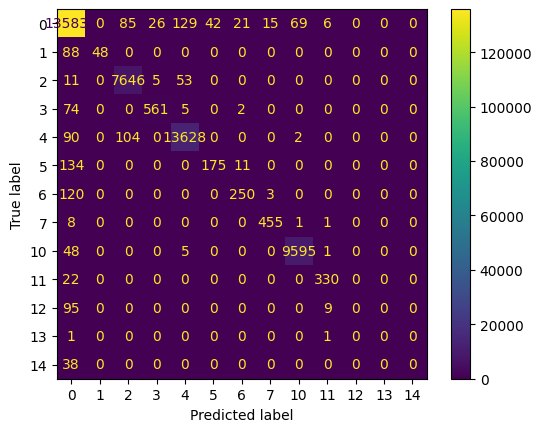

In [ ]:
model_sf_2.predict(X_test, Y_test)

In [ ]:
model_sf_3 = MulticlassClassification(
    78,
    [20, 20, 20],
    num_classes=15
)
model_sf_3.set_avg_weights([model_sf_1, model_sf_2])

Model: "server_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 20)                1580      
                                                                 
 dense_29 (Dense)            (None, 20)                420       
                                                                 
 dense_30 (Dense)            (None, 20)                420       
                                                                 
 dense_31 (Dense)            (None, 15)                315       
                                                                 
Total params: 2,735
Trainable params: 2,735
Non-trainable params: 0
_________________________________________________________________


5308/5308 [==============================] - 9s 2ms/step
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    136225
           1       0.00      0.00      0.00       136
           2       0.04      0.00      0.00      7715
           3       0.00      0.00      0.00       642
           4       0.00      0.00      0.00     13824
           5       0.00      0.00      0.00       320
           6       0.00      0.00      0.00       373
           7       0.00      0.00      0.00       465
          10       0.98      0.39      0.56      9649
          11       0.00      0.00      0.00       352
          12       0.00      0.00      0.00       104
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        38

    accuracy                           0.82    169845
   macro avg       0.14      0.11      0.11    169845
weighted avg       0.72      0.82      0.75    169845



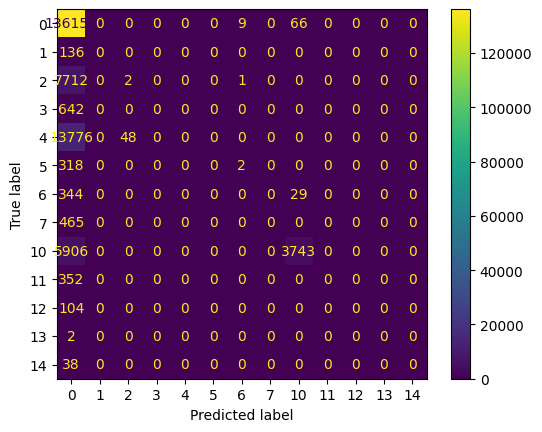

In [ ]:
model_sf_3.predict(X_test, Y_test)


- We see a similar reduction in accuracy which combined with the class imbalance hampered the usefullness of this model a lot.
- However, with proper handling of the class imbalance, we can remedy this.

## Never Ending Learning
### Anomaly Detection Using Isolation Forest

- To detect anomalous samples, we will use an isolation forest.

In [ ]:
from sklearn.ensemble import IsolationForest

isf = IsolationForest(random_state=1)
isf.fit(X)

IsolationForest(random_state=1)

In [ ]:
preds = isf.predict(X_train)

In [ ]:
num_anomaly = len([p for p in preds if p == -1])
print(f"{num_anomaly} anomalies found")

- We have found a number of anomalies, the only step remaining is to create new classes for them.

## Future Work
- After getting the anomalies, we can use an unsupervised learning method to cluster all the anomalous samples together.
- We can then use these clusters to create new classes and keep updating the model.

## Inferences
- The class imbalance hampered the multiclass classification, but the binary classification worked very well for the CICIDS dataset.
- Federated learning helped us to train a model without sharing any data between models. This can be essential in situations where the data is highly private and sharing it can be a huge security flaw.